In [1]:
pip install openslide-bin

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %% [markdown]
# # Projet de Classification des Cancers du Poumon
# **Objectif** : Classifier les types de cancer via des images .svs (Pathology Images) et annotations (Lung Cancer).

# %%
# Installation des bibliothèques (décommentez si nécessaire)
# Importations
import pandas as pd
#import openslide
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
# Charger les données
clinical = pd.read_csv("../Data/type/Lung Cancer/lung_cancer.csv")
pathology = pd.read_csv("../Data/type/Pathology Images/pathology_images.csv")

In [10]:
print("Colonnes dans clinical:", clinical.columns.tolist())
print("Colonnes dans pathology:", pathology.columns.tolist())

Colonnes dans clinical: ['dataset_version', 'pid', 'candx_days', 'clinical_m', 'clinical_m_7thed', 'clinical_n', 'clinical_n_7thed', 'clinical_stag', 'clinical_t', 'clinical_t_7thed', 'de_grade', 'de_stag', 'de_stag_7thed', 'de_type', 'first_lc', 'lc_behav', 'lc_grade', 'lc_morph', 'lc_order', 'lc_topog', 'lesionsize', 'loccar', 'loclhil', 'loclin', 'locllow', 'loclmsb', 'loclup', 'locmed', 'locoth', 'locrhil', 'locrlow', 'locrmid', 'locrmsb', 'locrup', 'locunk', 'path_m', 'path_m_7thed', 'path_n', 'path_n_7thed', 'path_stag', 'path_t', 'path_t_7thed', 'source_best_stage', 'stage_only', 'stage_sum', 'study_yr', 'topog_source', 'valcsg']
Colonnes dans pathology: ['dataset_version', 'pid', 'image_filename', 'image_filesize', 'lc_order', 'selected_path', 'selected_path_batch', 'block_annotated', 'block_color1', 'block_color2', 'block_color3', 'block_color4', 'block_color5', 'block_dnacore_cnt', 'block_dnacore_orig_cnt', 'block_dnacore_vials', 'block_has_dnacore', 'block_has_tmacore', 'blo

In [11]:
print("Valeurs uniques dans 'pid' (clinical):", clinical["pid"].unique()[:5])
print("Valeurs uniques dans 'pid' (pathology):", pathology["pid"].unique()[:5])

Valeurs uniques dans 'pid' (clinical): [100012 100049 100055 100147 100158]
Valeurs uniques dans 'pid' (pathology): [100012 100147 100158 100242 100280]


In [16]:
# Mapping des codes
cancer_types = {
    "8140/3": "Adenocarcinoma",
    "8070/3": "Squamous",
    "8250/3": "Bronchioalveolar"
}

merged = pd.merge(clinical, pathology, on="pid", how="inner")

# Fusion des sources
merged['label'] = (
    merged['lc_morph'].map(cancer_types)
    .fillna(merged['roi_histology_subtype1'])
    .fillna(merged['roi_WHO_class1'])  # Fallback supplémentaire
)

# Filtrage des cas non classés
final_df = merged.dropna(subset=['label'])

In [17]:
# Afficher 10 lignes aléatoires pour vérifier la fusion
print("Aperçu des données fusionnées (10 lignes aléatoires) :")
print(merged.sample(10)[["pid", "image_filename", "lc_morph", "label"]].to_string())

Aperçu des données fusionnées (10 lignes aléatoires) :
         pid   image_filename  lc_morph                     label
577   113324         9695.svs      8246      Large Cell Carcinoma
262   106507         9551.svs      8310            Non-Tumor Lung
86    102388        11278.svs      8070            Non-Tumor Lung
175   104960  NLSI0000180.svs      8012            Non-Tumor Lung
15    100381        11361.svs      8140     Acinar Adenocarcinoma
0     100012        11445.svs      8140     Acinar Adenocarcinoma
569   113176        11295.svs      8140     Acinar Adenocarcinoma
609   113918        10381.svs      8140     Acinar Adenocarcinoma
937   123123         9733.svs      8070            Non-Tumor Lung
1246  131910         9528.svs      8140  Papillary Adenocarcinoma


In [18]:
# Compter les valeurs NaN dans 'label'
nan_count = merged["label"].isna().sum()
total_rows = len(merged)
print(f"\nValeurs manquantes dans 'label' : {nan_count}/{total_rows} ({nan_count/total_rows:.1%})")


Valeurs manquantes dans 'label' : 46/1351 (3.4%)


In [19]:
# Afficher les valeurs uniques de 'lc_morph' non mappées
unmapped_codes = merged[merged['label'].isna()]['lc_morph'].unique()
print("Codes ICD-O non mappés dans cancer_types:\n", unmapped_codes)

Codes ICD-O non mappés dans cancer_types:
 [8140 8046 8070 8250 8249 8240 8041 8071]


In [20]:
cancer_types.update({
    "8140": "Adenocarcinoma",          # Adénocarcinome
    "8046": "Neuroendocrine Carcinoma",# Carcinome neuroendocrine
    "8070": "Squamous Cell Carcinoma", # Carcinome épidermoïde
    "8250": "Bronchioloalveolar Carcinoma", # Carcinome bronchio-alvéolaire
    "8249": "Atypical Carcinoid",      # Carcinoïde atypique
    "8240": "Carcinoid Tumor",         # Tumeur carcinoïde
    "8041": "Small Cell Carcinoma",    # Carcinome à petites cellules
    "8071": "Keratinizing Squamous Cell Carcinoma" # Carcinome épidermoïde kératinisant
})

In [21]:
# Nettoyer les codes (au cas où ils contiendraient des espaces ou autres caractères)
merged['lc_morph'] = merged['lc_morph'].astype(str).str.strip()

# Appliquer le mapping mis à jour
merged['label'] = merged['lc_morph'].map(cancer_types)

In [22]:
# Afficher les statistiques après correction
print("Valeurs manquantes après mapping:", merged['label'].isna().sum())
print("Distribution des labels:\n", merged['label'].value_counts(dropna=False))

# Afficher un échantillon des données corrigées
print("\nExemple de données corrigées:")
print(merged[['image_filename', 'lc_morph', 'label']].sample(5).to_string())

Valeurs manquantes après mapping: 196
Distribution des labels:
 label
Adenocarcinoma                          518
Squamous Cell Carcinoma                 298
NaN                                     196
Neuroendocrine Carcinoma                132
Bronchioloalveolar Carcinoma            127
Small Cell Carcinoma                     33
Keratinizing Squamous Cell Carcinoma     32
Carcinoid Tumor                          12
Atypical Carcinoid                        3
Name: count, dtype: int64

Exemple de données corrigées:
       image_filename lc_morph                     label
976         11380.svs     8070   Squamous Cell Carcinoma
938   NLSI0000120.svs     8140            Adenocarcinoma
301         11449.svs     8046  Neuroendocrine Carcinoma
1144        11121.svs     8252                       NaN
336   NLSI0000049.svs     8070   Squamous Cell Carcinoma


In [23]:
# Afficher les codes uniques non mappés
unmapped = merged[merged['label'].isna()]['lc_morph'].unique()
print("Codes non mappés restants:\n", unmapped)

Codes non mappés restants:
 ['8042' '8013' '8010' '8012' '8253' '8252' '8260' '8323' '8560' '8310'
 '8480' '8550' '8246' '8255' '8481' '8000' '8045' '8033' '8490' '8072']


In [24]:
# Mettre à jour le dictionnaire cancer_types avec les nouveaux codes
cancer_types.update({
    # Carcinomes à petites cellules
    "8042": "Small Cell Carcinoma, Combined",  # Carcinome à petites cellules combiné
    "8045": "Large Cell Neuroendocrine Carcinoma",  # Carcinome neuroendocrine à grandes cellules
    
    # Carcinomes non à petites cellules
    "8010": "Carcinoma, NOS",  # Carcinome non autrement spécifié
    "8012": "Large Cell Carcinoma, NOS",  # Carcinome à grandes cellules
    "8013": "Large Cell Neuroendocrine Carcinoma",  # Similaire à 8045
    
    # Adénocarcinomes spécifiques
    "8252": "Lepidic Predominant Adenocarcinoma",  # Adénocarcinome à prédominance lépidique
    "8253": "Adenocarcinoma with Mixed Subtypes",  # Adénocarcinome mixte
    "8255": "Adenocarcinoma with Colloid Features",  # Adénocarcinome colloïde
    "8260": "Papillary Adenocarcinoma",  # Adénocarcinome papillaire
    "8310": "Clear Cell Adenocarcinoma",  # Adénocarcinome à cellules claires
    "8480": "Mucinous Adenocarcinoma",  # Adénocarcinome mucineux
    "8481": "Mucin-Producing Adenocarcinoma",  # Adénocarcinome producteur de mucine
    "8550": "Acinar Cell Carcinoma",  # Carcinome à cellules acineuses
    "8560": "Adenosquamous Carcinoma",  # Carcinome adénosquameux
    
    # Tumeurs neuroendocrines
    "8246": "Neuroendocrine Carcinoma, NOS",  # Carcinome neuroendocrine
    "8249": "Atypical Carcinoid",  # Carcinoïde atypique
    
    # Autres
    "8000": "Neoplasm, Malignant",  # Néoplasme malin
    "8033": "Sarcomatoid Carcinoma",  # Carcinome sarcomatoïde
    "8072": "Non-Keratinizing Squamous Cell Carcinoma",  # Carcinome épidermoïde non kératinisant
    "8323": "Mixed Cell Adenocarcinoma",  # Adénocarcinome à cellules mixtes
    "8490": "Signet Ring Cell Carcinoma"  # Carcinome à cellules en bague à chaton
})

In [25]:
# Nettoyage final des codes
merged['lc_morph'] = merged['lc_morph'].astype(str).str.strip()

# Application du mapping complet
merged['label'] = merged['lc_morph'].map(cancer_types)

# Vérification des valeurs manquantes
print("Valeurs manquantes après mapping complet:", merged['label'].isna().sum())

Valeurs manquantes après mapping complet: 0


In [26]:
# Sauvegarde des données complètes
merged.to_csv("pathology_images_fully_labeled_v2.csv", index=False)

# Export des statistiques finales
label_stats = merged['label'].value_counts(dropna=False)
print("Distribution finale des labels:\n", label_stats)

# Optionnel : exporter les cas unclassified pour revue
if 'Unclassified' in label_stats:
    merged[merged['label'] == 'Unclassified'].to_csv("unclassified_cases_review.csv")

Distribution finale des labels:
 label
Adenocarcinoma                              518
Squamous Cell Carcinoma                     298
Neuroendocrine Carcinoma                    132
Bronchioloalveolar Carcinoma                127
Large Cell Carcinoma, NOS                    34
Small Cell Carcinoma                         33
Keratinizing Squamous Cell Carcinoma         32
Large Cell Neuroendocrine Carcinoma          31
Lepidic Predominant Adenocarcinoma           24
Adenosquamous Carcinoma                      15
Carcinoid Tumor                              12
Mucinous Adenocarcinoma                      12
Acinar Cell Carcinoma                        10
Carcinoma, NOS                                9
Mucin-Producing Adenocarcinoma                8
Neuroendocrine Carcinoma, NOS                 8
Adenocarcinoma with Colloid Features          8
Adenocarcinoma with Mixed Subtypes            7
Non-Keratinizing Squamous Cell Carcinoma      6
Papillary Adenocarcinoma                      6
S

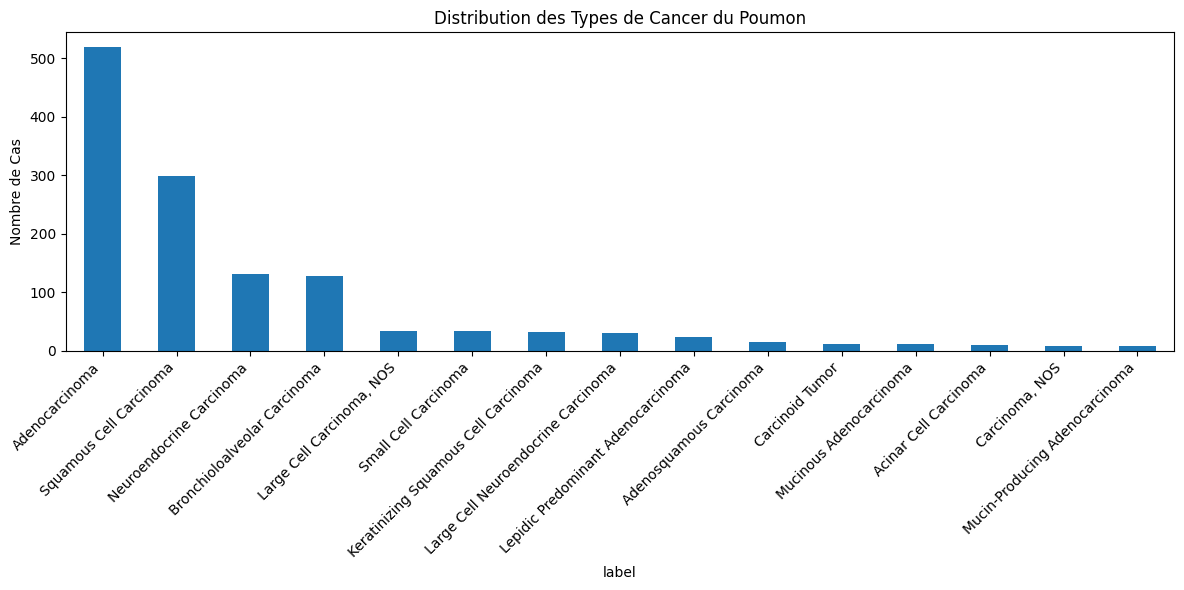

In [27]:
import matplotlib.pyplot as plt

# Diagramme des 15 principaux types
label_stats.head(15).plot(kind='bar', figsize=(12,6))
plt.title("Distribution des Types de Cancer du Poumon")
plt.ylabel("Nombre de Cas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [32]:
# Colonnes à garder (avec tous les sous-types ROI)
columns_to_keep = [
    # Identifiants
    'pid', 'image_filename',
    
    # Diagnostics globaux
    'lc_morph', 'label', 'block_worst_grade',
    
    # Annotations ROI (tous les sous-types)
    *[f'roi_histology_subtype{i}' for i in range(1, 7)],
    *[f'roi_WHO_class{i}' for i in range(1, 7)],
    *[f'roi_highest_grade{i}' for i in range(1, 7)],
    
    # Métadonnées
    'selected_path', 'block_annotated'
]

# Nettoyage ciblé
df_clean = merged[columns_to_keep].copy()

# Gestion des valeurs manquantes
for i in range(1, 7):
    # Harmonisation des sous-types vides
    df_clean[f'roi_histology_subtype{i}'] = df_clean[f'roi_histology_subtype{i}'].replace('', np.nan)
    
    # Remplissage des grades manquants
    df_clean[f'roi_highest_grade{i}'] = df_clean[f'roi_highest_grade{i}'].fillna('GX')  # GX = non évalué

# Création d'une colonne composite pour le sous-type majoritaire
df_clean['dominant_subtype'] = (
    df_clean[[f'roi_histology_subtype{i}' for i in range(1, 7)]]
    .mode(axis=1)[0]  # Prend le sous-type le plus fréquent par ligne
)

In [33]:
# Vérification de la cohérence entre sous-types ROI
for i in range(1, 6):
    for j in range(i+1, 7):
        conflicts = sum(
            (df_clean[f'roi_histology_subtype{i}'].notna()) &
            (df_clean[f'roi_histology_subtype{j}'].notna()) &
            (df_clean[f'roi_histology_subtype{i}'] != df_clean[f'roi_histology_subtype{j}'])
        )
        print(f"Conflits entre ROI{i} et ROI{j}: {conflicts}")

# Export des cas avec sous-types contradictoires
conflict_mask = (
    df_clean[[f'roi_histology_subtype{i}' for i in range(1, 7)]]
    .nunique(axis=1) > 1  # Si au moins 2 sous-types différents
)
df_conflicts = df_clean[conflict_mask]
df_conflicts.to_csv("subtype_conflicts.csv", index=False)

Conflits entre ROI1 et ROI2: 635
Conflits entre ROI1 et ROI3: 339
Conflits entre ROI1 et ROI4: 105
Conflits entre ROI1 et ROI5: 9
Conflits entre ROI1 et ROI6: 2
Conflits entre ROI2 et ROI3: 138
Conflits entre ROI2 et ROI4: 77
Conflits entre ROI2 et ROI5: 8
Conflits entre ROI2 et ROI6: 2
Conflits entre ROI3 et ROI4: 61
Conflits entre ROI3 et ROI5: 7
Conflits entre ROI3 et ROI6: 2
Conflits entre ROI4 et ROI5: 4
Conflits entre ROI4 et ROI6: 2
Conflits entre ROI5 et ROI6: 2


In [34]:
# Définir la hiérarchie complète des ROI (de la plus à la moins fiable)
hierarchy = [
    'roi_histology_subtype1',  # Annotation principale
    'roi_histology_subtype2',  # Second avis
    'roi_histology_subtype3',  # Troisième annotation
    'roi_histology_subtype4',  # ...
    'roi_histology_subtype5',
    'roi_histology_subtype6'   # Dernière ROI
]

# Créer la colonne finale en priorisant les ROI de gauche à droite
df_clean['final_subtype'] = (
    df_clean[hierarchy]
    .bfill(axis=1)  # Remonte la première valeur non-nulle vers la gauche
    .iloc[:, 0]     # Prend la première colonne (ROI prioritaire remplie)
)


C:\Users\USER\AppData\Local\Temp\ipykernel_1332\750213535.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .bfill(axis=1)  # Remonte la première valeur non-nulle vers la gauche


In [35]:
def coalesce_subtypes(row):
    for i in range(1, 7):
        subtype = row[f'roi_histology_subtype{i}']
        if pd.notna(subtype):
            return subtype
    return 'Unclassified'

df_clean['final_subtype'] = df_clean.apply(coalesce_subtypes, axis=1)

In [36]:
print("Valeurs manquantes :", df_clean['final_subtype'].isna().sum())
print("Distribution :\n", df_clean['final_subtype'].value_counts(dropna=False))

Valeurs manquantes : 0
Distribution :
 final_subtype
Non-Tumor Lung                                                       395
Squamous Cell Carcinoma                                              216
Acinar Adenocarcinoma                                                204
Large Cell Carcinoma                                                  64
BAC Nonmucinous                                                       57
Papillary Adenocarcinoma                                              54
Adenocarcinoma, Mixed Subtype                                         49
Unclassified                                                          46
Adenocarcinoma, NOS                                                   38
Large Cell Neuroendocrine Carcinoma                                   30
Squamous Cell Carcinoma, Basaloid                                     30
Small Cell Carcinoma                                                  30
Clear Cell Adenocarcinoma                                             2

In [37]:
# Dictionnaire de standardisation
label_mapping = {
    # Consolidation des adénocarcinomes
    'Acinar Adenocarcinoma': 'Adenocarcinoma (Acinar)',
    'Papillary Adenocarcinoma': 'Adenocarcinoma (Papillary)',
    'Solid Adenocarcinoma with mucin production': 'Adenocarcinoma (Solid)',
    'BAC Nonmucinous': 'Adenocarcinoma (Lepidic)',
    'BAC Mucinous': 'Adenocarcinoma (Mucinous)',
    
    # Standardisation des carcinomes épidermoïdes
    'Squamous Cell Carcinoma': 'Squamous Carcinoma',
    'Squamous Cell Carcinoma, Basaloid': 'Squamous Carcinoma (Basaloid)',
    
    # Cas spéciaux
    'Non-Tumor Lung': 'Non-Tumor',
    'Normal Lymph Node': 'Non-Tumor',
    'Unclassified': 'Unknown'
}

df_clean['standard_label'] = df_clean['final_subtype'].map(label_mapping).fillna(df_clean['final_subtype'])

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
subtype_matrix = pd.DataFrame(
    mlb.fit_transform(df_clean['standard_label'].str.split(';')),
    columns=mlb.classes_
)


ModuleNotFoundError: No module named 'sklearn'

In [37]:
unknown_cases = df_clean[df_clean['standard_label'] == 'Unknown']

# Vérifier les ROI associées
print("Répartition des ROI pour les cas Unknown:")
print(unknown_cases[[f'roi_histology_subtype{i}' for i in range(1,7)]].apply(pd.Series.value_counts))

Répartition des ROI pour les cas Unknown:
Empty DataFrame
Columns: [roi_histology_subtype1, roi_histology_subtype2, roi_histology_subtype3, roi_histology_subtype4, roi_histology_subtype5, roi_histology_subtype6]
Index: []


In [39]:
# Version standardisée
print("\nDistribution standardisée:")
print(df_clean['standard_label'].value_counts(dropna=False))




Distribution standardisée:
standard_label
Non-Tumor                                                            415
Squamous Carcinoma                                                   216
Adenocarcinoma (Acinar)                                              204
Large Cell Carcinoma                                                  64
Adenocarcinoma (Lepidic)                                              57
Adenocarcinoma (Papillary)                                            54
Adenocarcinoma, Mixed Subtype                                         49
Unknown                                                               46
Adenocarcinoma, NOS                                                   38
Large Cell Neuroendocrine Carcinoma                                   30
Small Cell Carcinoma                                                  30
Squamous Carcinoma (Basaloid)                                         30
Clear Cell Adenocarcinoma                                             25
Adenocar

In [40]:
print("Colonnes disponibles dans df_clean :")
print(df_clean.columns.tolist())

Colonnes disponibles dans df_clean :
['pid', 'image_filename', 'dataset_version', 'lc_morph', 'label', 'block_worst_grade', 'roi_histology_subtype1', 'roi_histology_subtype2', 'roi_histology_subtype3', 'roi_histology_subtype4', 'roi_histology_subtype5', 'roi_histology_subtype6', 'roi_WHO_class1', 'roi_WHO_class2', 'roi_WHO_class3', 'roi_WHO_class4', 'roi_WHO_class5', 'roi_WHO_class6', 'roi_highest_grade1', 'roi_highest_grade2', 'roi_highest_grade3', 'roi_highest_grade4', 'roi_highest_grade5', 'roi_highest_grade6', 'selected_path', 'block_annotated', 'dominant_subtype', 'final_subtype', 'standard_label']


In [41]:
# Création sécurisée de la colonne primary_subtype
df_clean['primary_subtype'] = (
    df_clean['standard_label']  # Utilisez 'final_subtype' si 'standard_label' n'existe pas
    .str.split(';')
    .str[0]
    .fillna('Unknown')  # Gestion des cas vides
)

In [42]:
# Colonnes prioritaires à exporter (ajustez selon vos besoins)
export_columns = [
    'pid',
    'image_filename',
    'final_subtype',    # Sous-type original
    'standard_label',   # Sous-type standardisé
    'primary_subtype',  # Sous-type principal simplifié
    'block_worst_grade',# Grade tumoral
    'block_annotated'   # Validation par expert
]

# Filtrage des colonnes existantes
available_columns = [col for col in export_columns if col in df_clean.columns]

In [43]:
# Export vers CSV
df_clean.to_csv(
    "cleaned_subtypes_with_mapping.csv",
    columns=available_columns,
    index=False,
    encoding='utf-8-sig'  # Pour une bonne lecture des caractères spéciaux
)

In [44]:
print(f"Colonnes exportées ({len(available_columns)}):")
print(available_columns)

print("\nAperçu des données exportées :")
print(df_clean[available_columns].head(3))

Colonnes exportées (7):
['pid', 'image_filename', 'final_subtype', 'standard_label', 'primary_subtype', 'block_worst_grade', 'block_annotated']

Aperçu des données exportées :
      pid image_filename          final_subtype           standard_label  \
0  100012      11445.svs  Acinar Adenocarcinoma  Adenocarcinoma (Acinar)   
1  100012      11446.svs  Acinar Adenocarcinoma  Adenocarcinoma (Acinar)   
2  100012      11447.svs         Non-Tumor Lung                Non-Tumor   

           primary_subtype  block_worst_grade  block_annotated  
0  Adenocarcinoma (Acinar)                4.0                1  
1  Adenocarcinoma (Acinar)                4.0                1  
2                Non-Tumor                4.0                1  


Distribution des classes :
 standard_label
Non-Tumor                                                            0.307180
Squamous Carcinoma                                                   0.159882
Adenocarcinoma (Acinar)                                              0.150999
Large Cell Carcinoma                                                 0.047372
Adenocarcinoma (Lepidic)                                             0.042191
Adenocarcinoma (Papillary)                                           0.039970
Adenocarcinoma, Mixed Subtype                                        0.036269
Unknown                                                              0.034049
Adenocarcinoma, NOS                                                  0.028127
Large Cell Neuroendocrine Carcinoma                                  0.022206
Small Cell Carcinoma                                                 0.022206
Squamous Carcinoma (Basaloid)                                        0.022206
Clear Cell Adenocarci

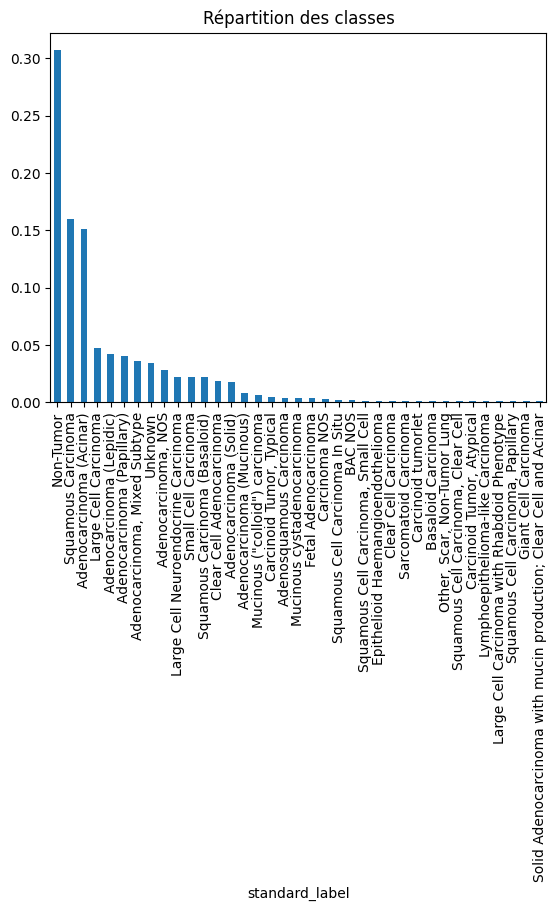

In [45]:
df = pd.read_csv("cleaned_subtypes_with_mapping.csv")
class_distribution = df["standard_label"].value_counts(normalize=True)

print("Distribution des classes :\n", class_distribution)
# Visualisation
import matplotlib.pyplot as plt
class_distribution.plot(kind='bar', title='Répartition des classes')
plt.show()

In [54]:
CLASS_MAPPING = {
    # Groupes principaux (>5%)
    "Non-Tumor": "Non-Tumor",
    "Squamous Carcinoma": "Squamous_Carcinoma",
    "Adenocarcinoma (Acinar)": "Adenocarcinoma_Major",
    "Large Cell Carcinoma": "LargeCell_Carcinoma",
    
    # Fusion des adénocarcinomes variants
    "Adenocarcinoma (Lepidic)": "Adenocarcinoma_Major",
    "Adenocarcinoma (Papillary)": "Adenocarcinoma_Major",
    "Adenocarcinoma, Mixed Subtype": "Adenocarcinoma_Major",
    
    # Fusion des carcinomes neuroendocrines
    "Large Cell Neuroendocrine Carcinoma": "Neuroendocrine_Carcinoma",
    "Small Cell Carcinoma": "Neuroendocrine_Carcinoma",
    "BAC NOS": "BAC NOS",
    
    # Autres fusions critiques
    **{cls: "Rare_Carcinoma" for cls in df["standard_label"].unique() 
       if df[df["standard_label"]==cls].shape[0] < 10 and cls != "BAC NOS"}
}

Nouvelle distribution des classes (%):
regrouped_label
Non-Tumor                   35.26
Adenocarcinoma_Major        30.93
Squamous_Carcinoma          18.35
LargeCell_Carcinoma          5.44
Neuroendocrine_Carcinoma     5.10
Rare_Carcinoma               4.67
BAC NOS                      0.25


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15228\1751698600.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=new_distribution.index,


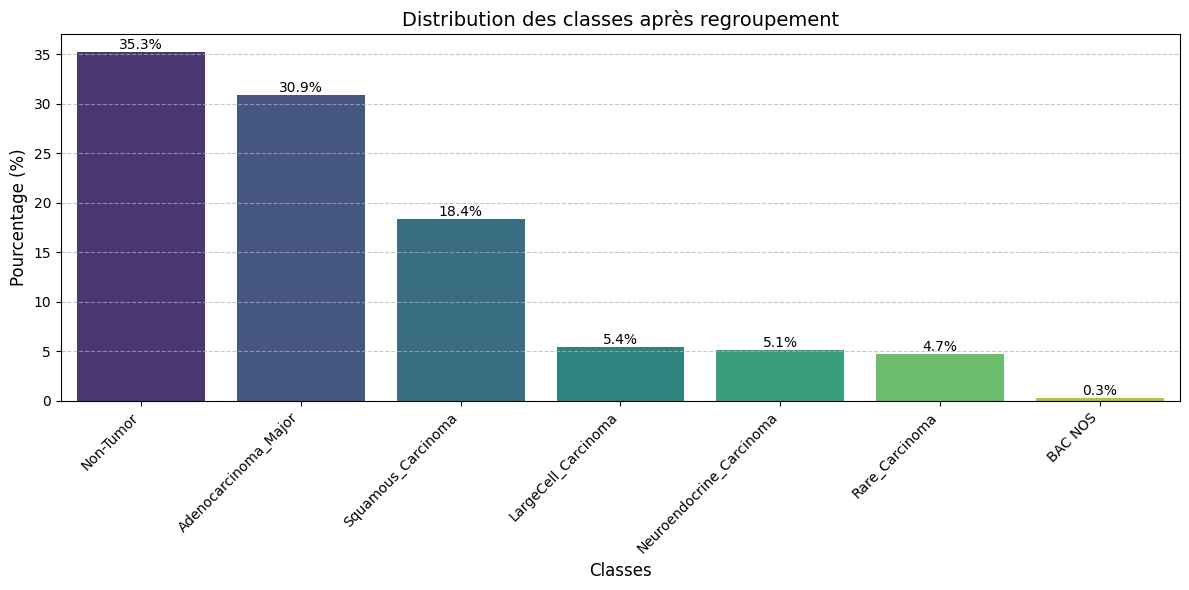

In [55]:
import seaborn as sns
df["regrouped_label"] = df["standard_label"].map(CLASS_MAPPING)

# 2. Calcul de la nouvelle distribution
new_distribution = df["regrouped_label"].value_counts(normalize=True).sort_values(ascending=False) * 100

# 3. Affichage texte
print("Nouvelle distribution des classes (%):")
print(new_distribution.round(2).to_string())

# 4. Visualisation
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=new_distribution.index, 
                 y=new_distribution.values,
                 palette="viridis")

# Personnalisation du plot
plt.title("Distribution des classes après regroupement", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Pourcentage (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajout des valeurs sur les barres
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [1]:
pip install tensorflow-gpu==2.10.0  # Dernière version compatible
pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html

SyntaxError: invalid syntax (172190897.py, line 1)

In [1]:
!pip install tensorflow-gpu==2.10.0

     -------------------------------------- 455.9/455.9 MB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 5.9/5.9 MB 3.4 MB/s eta 0:00:00
     -------------------------------------- 895.7/895.7 kB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 3.6 MB/s eta 0:00:00
     -------------------------------------- 438.7/438.7 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 42.6/42.6 kB 2.2 MB/s eta 0:00:00
     -------------------------------------- 210.8/210.8 kB 4.3 MB/s eta 0:00:00
     -------------------------------------- 781.3/781.3 kB 4.1 MB/s eta 0:00:00
     -------------------------------------- 181.3/181.3 kB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 83.1/83.1 kB 2.4 MB/s eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.9.0
    Uninstalling keras-3.9.0:
      Successfully 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires keras>=3.5.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.10.1 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [ ]:
pip install --upgrade tensorflow

     -------------------------------------- 375.7/375.7 MB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 3.1 MB/s eta 0:00:00
     -------------------------------------- 209.7/209.7 kB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 1.6 MB/s eta 0:00:00
     -------------------------------------- 434.5/434.5 kB 2.5 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'D:\\PLUMOSCAN\\PulmoScan\\venv\\Lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp310-win_amd64.pyd'
Check the permissions.


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Vérifier que TensorFlow détecte le GPU
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2025-04-03 18:03:19.147583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2025-04-03 18:03:19.148181: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "d:\PLUMOSCAN\PulmoScan\venv\lib\site-packages\tensorflow\__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "d:\PLUMOSCAN\PulmoScan\venv\lib\site-packages\tensorflow\python\__init__.py", line 37, in <module>
    from tensorflow.python.eager import context
  File "d:\PLUMOSCAN\PulmoScan\venv\lib\site-packages\tensorflow\python\eager\context.py", line 29, in <module>
    from tensorflow.core.framework import function_pb2
  File "d:\PLUMOSCAN\PulmoScan\venv\lib\site-packages\tensorflow\core\framework\function_pb2.py", l

In [9]:
# Désinstaller les versions existantes
!pip uninstall tensorflow -y

# Installer TensorFlow 2.10 avec CUDA 11.2
!pip install tensorflow==2.10.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


     -------------------------------------- 455.9/455.9 MB 1.4 MB/s eta 0:00:00
  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl (895 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'D:\\PLUMOSCAN\\PulmoScan\\venv\\Lib\\site-packages\\tensorflow\\python\\_pywrap_py_exception_registry.pyd'
Check the permissions.


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# Mettre à jour protobuf
!pip install --upgrade protobuf==3.20.3

     -------------------------------------- 904.0/904.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires keras>=3.5.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-gpu 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
